1) imports, paths, folders

In [1]:
import os, sqlite3, warnings, json, itertools
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

DATA_PATH = "/Users/chiagoziemcyriacusugoh/Copy1-Emissions_Renewables_Merged.csv"
OUTDIR = "/Users/chiagoziemcyriacusugoh"
PLOTS_DIR = os.path.join(OUTDIR, "plots_html")
EDA_DIR = os.path.join(OUTDIR, "eda_csv")
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(EDA_DIR, exist_ok=True)
STREAMLIT_DIR = OUTDIR

DB_PATH = os.path.join(OUTDIR, "emissions_un_m49.db")

print('DATA_PATH:', DATA_PATH)
print('OUTDIR:', OUTDIR)

DATA_PATH: /Users/chiagoziemcyriacusugoh/Copy1-Emissions_Renewables_Merged.csv
OUTDIR: /Users/chiagoziemcyriacusugoh


2) load & clean (index-safe)

In [2]:
# 2.1 Load
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
# normalize key column names (case differences)
df = df.rename(columns={"co2":"CO2", "co2_per_capita":"CO2_per_capita", "total_ghg":"Total_GHG"})

# 2.2 Coerce numerics
num_cols = ["Renewables_equivalent_primary_energy", "CO2", "CO2_per_capita", "Total_GHG", "Year"]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 2.3 basic cleaning
df = df.dropna(subset=["Country", "Year", "CO2"]).copy()
df["Renewables_equivalent_primary_energy"] = df["Renewables_equivalent_primary_energy"].fillna(0)
df["Total_GHG"] = df["Total_GHG"].fillna(df["CO2"])  # fallback if missing
for col in ["Renewables_equivalent_primary_energy", "CO2", "CO2_per_capita", "Total_GHG"]:
    if col in df.columns:
        df.loc[df[col] < 0, col] = np.nan

# 2.4 sort and index-safe forward/backward fill within Country
df = df.sort_values(["Country", "Year"]).reset_index(drop=True)
cols_fill = [c for c in ["CO2","CO2_per_capita","Total_GHG","Renewables_equivalent_primary_energy"] if c in df.columns]
if cols_fill:
    df[cols_fill] = df.groupby("Country")[cols_fill].transform(lambda g: g.ffill().bfill())

df.head()

,Country,Year,Renewables_equivalent_primary_energy,CO2,CO2_per_capita,Total_GHG
0,Algeria,1990,0.119067,76.738,3.024,160.869
1,Algeria,1991,0.260826,78.807,3.032,169.126
2,Algeria,1992,0.172640,79.883,3.000,165.198
3,Algeria,1993,0.329121,81.944,3.004,171.063
4,Algeria,1994,0.152741,88.608,3.177,175.045


3) region mapping → 6 canonical regions (+ “Global” rollups later)

In [3]:
UN_TO_SUBREG = {
 'Algeria':'Northern Africa','Argentina':'South America','Australia':'Australia and New Zealand','Austria':'Western Europe',
 'Azerbaijan':'Western Asia','Bangladesh':'Southern Asia','Belarus':'Eastern Europe','Belgium':'Western Europe','Brazil':'South America',
 'Bulgaria':'Eastern Europe','Canada':'Northern America','Chile':'South America','China':'Eastern Asia','Colombia':'South America',
 'Croatia':'Southern Europe','Cyprus':'Southern Europe','Czechia':'Eastern Europe','Denmark':'Northern Europe','Ecuador':'South America',
 'Egypt':'Northern Africa','Estonia':'Northern Europe','Finland':'Northern Europe','France':'Western Europe','Germany':'Western Europe',
 'Greece':'Southern Europe','Hong Kong':'Eastern Asia','Hungary':'Eastern Europe','Iceland':'Northern Europe','India':'Southern Asia',
 'Indonesia':'South-eastern Asia','Iran':'Southern Asia','Iraq':'Western Asia','Ireland':'Northern Europe','Israel':'Western Asia',
 'Italy':'Southern Europe','Japan':'Eastern Asia','Kazakhstan':'Central Asia','Kuwait':'Western Asia','Latvia':'Northern Europe',
 'Lithuania':'Northern Europe','Luxembourg':'Western Europe','Malaysia':'South-eastern Asia','Mexico':'Central America',
 'Morocco':'Northern Africa','Netherlands':'Western Europe','New Zealand':'Australia and New Zealand','North Macedonia':'Southern Europe',
 'Norway':'Northern Europe','Oman':'Western Asia','Pakistan':'Southern Asia','Peru':'South America','Philippines':'South-eastern Asia',
 'Poland':'Eastern Europe','Portugal':'Southern Europe','Qatar':'Western Asia','Romania':'Eastern Europe','Russia':'Eastern Europe',
 'Saudi Arabia':'Western Asia','Singapore':'South-eastern Asia','Slovakia':'Eastern Europe','Slovenia':'Southern Europe',
 'South Africa':'Southern Africa','South Korea':'Eastern Asia','Spain':'Southern Europe','Sri Lanka':'Southern Asia','Sweden':'Northern Europe',
 'Switzerland':'Western Europe','Taiwan':'Eastern Asia','Thailand':'South-eastern Asia','Trinidad and Tobago':'Latin America and the Caribbean',
 'Turkey':'Western Asia','Turkmenistan':'Central Asia','Ukraine':'Eastern Europe','United Arab Emirates':'Western Asia',
 'United Kingdom':'Northern Europe','United States':'Northern America','Uzbekistan':'Central Asia','Venezuela':'South America','Vietnam':'South-eastern Asia'
}
SUBREG_TO_REGION = {
 'Northern Africa':'Africa','Southern Africa':'Africa','Middle Africa':'Africa','Western Africa':'Africa','Eastern Africa':'Africa',
 'Southern Europe':'Europe','Northern Europe':'Europe','Western Europe':'Europe','Eastern Europe':'Europe',
 'Central Asia':'Asia','Eastern Asia':'Asia','South-eastern Asia':'Asia','Southern Asia':'Asia','Western Asia':'Asia',
 'Central America':'North America','Northern America':'North America',
 'South America':'South America','Latin America and the Caribbean':'South America',
 'Australia and New Zealand':'Australia','Oceania':'Australia','Other':'Other'
}

df["UN_Region"] = df["Country"].map(UN_TO_SUBREG).fillna("Other")
df["Region_Canonical"] = df["UN_Region"].map(SUBREG_TO_REGION).fillna("Other")

df[["Country", "UN_Region", "Region_Canonical"]].head(10)

,Country,UN_Region,Region_Canonical
0,Algeria,Northern Africa,Africa
1,Algeria,Northern Africa,Africa
2,Algeria,Northern Africa,Africa
3,Algeria,Northern Africa,Africa
4,Algeria,Northern Africa,Africa
5,Algeria,Northern Africa,Africa
6,Algeria,Northern Africa,Africa
7,Algeria,Northern Africa,Africa
8,Algeria,Northern Africa,Africa
9,Algeria,Northern Africa,Africa


4) feature engineering (intensities, yoy growth, lags)

In [4]:
# YoY growth
df["Renewables_grow_yoy"] = df.groupby("Country")["Renewables_equivalent_primary_energy"].pct_change()
df["CO2_grow_yoy"] = df.groupby("Country")["CO2"].pct_change()

# Intensity per renewable unit
df["CO2_per_renewable_unit"] = df["CO2"] / df["Renewables_equivalent_primary_energy"].replace(0, np.nan)

# Simple lags (for potential ML usage later)
for lag in [1, 2]:
    df[f"CO2_lag{lag}"] = df.groupby("Country")["CO2"].shift(lag)
    df[f"Renewables_lag{lag}"] = df.groupby("Country")["Renewables_equivalent_primary_energy"].shift(lag)

df.head(12)

,Country,Year,Renewables_equivalent_primary_energy,CO2,CO2_per_capita,Total_GHG,UN_Region,Region_Canonical,Renewables_grow_yoy,CO2_grow_yoy,CO2_per_renewable_unit,CO2_lag1,Renewables_lag1,CO2_lag2,Renewables_lag2
0,Algeria,1990,0.119067,76.738,3.024,160.869,Northern Africa,Africa,NaN,NaN,644.495954,NaN,NaN,NaN,NaN
1,Algeria,1991,0.260826,78.807,3.032,169.126,Northern Africa,Africa,1.190590,0.026962,302.143657,76.738,0.119067,NaN,NaN
2,Algeria,1992,0.172640,79.883,3.000,165.198,Northern Africa,Africa,-0.338104,0.013654,462.714614,78.807,0.260826,76.738,0.119067
3,Algeria,1993,0.329121,81.944,3.004,171.063,Northern Africa,Africa,0.906401,0.025800,248.978438,79.883,0.172640,78.807,0.260826
4,Algeria,1994,0.152741,88.608,3.177,175.045,Northern Africa,Africa,-0.535913,0.081324,580.120312,81.944,0.329121,79.883,0.172640
5,Algeria,1995,0.171221,96.777,3.399,192.565,Northern Africa,Africa,0.120992,0.092193,565.216223,88.608,0.152741,81.944,0.329121
6,Algeria,1996,0.121007,100.039,3.446,196.756,Northern Africa,Africa,-0.293273,0.033706,826.723774,96.777,0.171221,88.608,0.152741
7,Algeria,1997,0.069947,88.369,2.988,179.375,Northern Africa,Africa,-0.421960,-0.116655,1263.378243,100.039,0.121007,96.777,0.171221
8,Algeria,1998,0.193708,106.537,3.545,196.014,Northern Africa,Africa,1.769371,0.205592,549.987468,88.369,0.069947,100.039,0.121007
9,Algeria,1999,0.181083,91.449,3.001,183.054,Northern Africa,Africa,-0.065175,-0.141622,505.011152,106.537,0.193708,88.369,0.069947


In [5]:
df.shape

(2686, 15)

In [6]:
df.isnull().sum()

Country                                   0
Year                                      0
Renewables_equivalent_primary_energy      0
CO2                                       0
CO2_per_capita                            0
Total_GHG                                 0
UN_Region                                 0
Region_Canonical                          0
Renewables_grow_yoy                     210
CO2_grow_yoy                             79
CO2_per_renewable_unit                  139
CO2_lag1                                 79
Renewables_lag1                          79
CO2_lag2                                158
Renewables_lag2                         158
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.shape

(2405, 15)

In [9]:
df.head(12)

,Country,Year,Renewables_equivalent_primary_energy,CO2,CO2_per_capita,Total_GHG,UN_Region,Region_Canonical,Renewables_grow_yoy,CO2_grow_yoy,CO2_per_renewable_unit,CO2_lag1,Renewables_lag1,CO2_lag2,Renewables_lag2
2,Algeria,1992,0.172640,79.883,3.000,165.198,Northern Africa,Africa,-0.338104,0.013654,462.714614,78.807,0.260826,76.738,0.119067
3,Algeria,1993,0.329121,81.944,3.004,171.063,Northern Africa,Africa,0.906401,0.025800,248.978438,79.883,0.172640,78.807,0.260826
4,Algeria,1994,0.152741,88.608,3.177,175.045,Northern Africa,Africa,-0.535913,0.081324,580.120312,81.944,0.329121,79.883,0.172640
5,Algeria,1995,0.171221,96.777,3.399,192.565,Northern Africa,Africa,0.120992,0.092193,565.216223,88.608,0.152741,81.944,0.329121
6,Algeria,1996,0.121007,100.039,3.446,196.756,Northern Africa,Africa,-0.293273,0.033706,826.723774,96.777,0.171221,88.608,0.152741
7,Algeria,1997,0.069947,88.369,2.988,179.375,Northern Africa,Africa,-0.421960,-0.116655,1263.378243,100.039,0.121007,96.777,0.171221
8,Algeria,1998,0.193708,106.537,3.545,196.014,Northern Africa,Africa,1.769371,0.205592,549.987468,88.369,0.069947,100.039,0.121007
9,Algeria,1999,0.181083,91.449,3.001,183.054,Northern Africa,Africa,-0.065175,-0.141622,505.011152,106.537,0.193708,88.369,0.069947
10,Algeria,2000,0.050011,85.399,2.763,183.103,Northern Africa,Africa,-0.723825,-0.066157,1707.615595,91.449,0.181083,106.537,0.193708
11,Algeria,2001,0.061328,86.839,2.772,175.084,Northern Africa,Africa,0.226297,0.016862,1415.977913,85.399,0.050011,91.449,0.181083


In [10]:
df.isnull().sum()

Country                                 0
Year                                    0
Renewables_equivalent_primary_energy    0
CO2                                     0
CO2_per_capita                          0
Total_GHG                               0
UN_Region                               0
Region_Canonical                        0
Renewables_grow_yoy                     0
CO2_grow_yoy                            0
CO2_per_renewable_unit                  0
CO2_lag1                                0
Renewables_lag1                         0
CO2_lag2                                0
Renewables_lag2                         0
dtype: int64

5) write to sqlite3 and run baseline SQL EDA

In [11]:
# Create DB
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
conn = sqlite3.connect(DB_PATH)
df.to_sql("emissions", conn, index=False)

2405

In [12]:
# 5.1 high-level stats
stats_sql = """
SELECT 
    COUNT(*) AS rows_total,
    COUNT(DISTINCT Country) AS countries,
    MIN(Year) AS year_min,
    MAX(Year) AS year_max
FROM emissions;
"""
stats = pd.read_sql(stats_sql, conn)
display(stats)

,rows_total,countries,year_min,year_max
0,2405,79,1992,2023


In [13]:
# 5.2 region-year aggregates
reg_sql = """
SELECT Region_Canonical AS Region, Year,
       SUM(Renewables_equivalent_primary_energy) AS renewables_sum,
       SUM(CO2) AS co2_sum,
       SUM(Total_GHG) AS ghg_sum,
       AVG(CO2_per_capita) AS co2pc_avg,
       COUNT(DISTINCT Country) AS countries
FROM emissions
GROUP BY Region, Year
ORDER BY Region, Year;
"""
by_region_year = pd.read_sql(reg_sql, conn)
display(by_region_year.head(12))

,Region,Year,renewables_sum,co2_sum,ghg_sum,co2pc_avg,countries
0,Africa,1992,10.201364,485.885,827.017,3.09500,4
1,Africa,1993,8.836401,521.346,864.199,3.22875,4
2,Africa,1994,9.914224,543.803,879.627,3.33275,4
3,Africa,1995,9.094689,586.215,937.433,3.52900,4
4,Africa,1996,12.497541,591.247,939.599,3.51725,4
5,Africa,1997,12.656656,615.275,961.217,3.53950,4
6,Africa,1998,11.727968,639.706,976.597,3.65325,4
7,Africa,1999,9.331571,626.547,965.378,3.48925,4
8,Africa,2000,9.285951,640.741,979.319,3.48025,4
9,Africa,2001,9.726657,622.926,952.126,3.39300,4


In [14]:
# 5.3 top emitters (lifetime)
top_emit_sql = """
SELECT Country, SUM(CO2) AS co2_total
FROM emissions
GROUP BY Country
ORDER BY co2_total DESC
LIMIT 10;
"""
top_emitters = pd.read_sql(top_emit_sql, conn)
display(top_emitters)

,Country,co2_total
0,China,226520.825
1,United States,177570.130
2,Russia,52338.735
3,India,51249.237
4,Japan,38728.081
5,Germany,26770.964
6,Canada,17540.384
7,South Korea,16712.374
8,Iran,16335.493
9,United Kingdom,15811.423


6) regional analysis (Africa, Europe, Asia, N. America, S. America, Australia)

In [15]:
def regional_summary(by_region_year: pd.DataFrame, region: str):
    g = by_region_year[by_region_year["Region"]==region].copy()
    # correlations among yearly sums
    corr = g[["renewables_sum","co2_sum","ghg_sum"]].corr()
    # growth rates
    g = g.sort_values("Year")
    g["co2_yoy"] = g["co2_sum"].pct_change()
    g["ren_yoy"] = g["renewables_sum"].pct_change()
    g["ghg_yoy"] = g["ghg_sum"].pct_change()
    # simple descriptive stats
    desc = g[["renewables_sum","co2_sum","ghg_sum"]].describe().T
    return g, corr, desc

regions = ["Africa","Europe","Asia","North America","South America","Australia"]
regional_outputs = {}
for r in regions:
    g, corr, desc = regional_summary(by_region_year, r)
    regional_outputs[r] = {"data": g, "corr": corr, "desc": desc}

# Show one example (Europe)
display(regional_outputs["Europe"]["desc"])
display(regional_outputs["Europe"]["corr"])
regional_outputs["Europe"]["data"].tail(10)

,count,mean,std,min,25%,50%,75%,max
renewables_sum,32.0,492.022107,139.721682,342.202977,379.858437,421.318838,602.798164,815.263507
co2_sum,32.0,5949.680125,508.257336,4905.671000,5531.182000,6083.547500,6330.824750,6979.466000
ghg_sum,32.0,7585.959063,550.409359,6587.303000,7282.166750,7600.284500,7795.770250,9076.088000


,renewables_sum,co2_sum,ghg_sum
renewables_sum,1.000000,-0.949417,-0.834655
co2_sum,-0.949417,1.000000,0.929126
ghg_sum,-0.834655,0.929126,1.000000


,Region,Year,renewables_sum,co2_sum,ghg_sum,co2pc_avg,countries,co2_yoy,ren_yoy,ghg_yoy
118,Europe,2014,599.430875,5530.873,7058.575,7.188882,34,-0.038276,0.042765,-0.045824
119,Europe,2015,604.141183,5531.285,7297.764,7.093176,34,0.000074,0.007858,0.033886
120,Europe,2016,607.604193,5512.319,7262.333,7.110000,34,-0.003429,0.005732,-0.004855
121,Europe,2017,602.350491,5544.734,7260.159,7.168147,34,0.005880,-0.008647,-0.000299
122,Europe,2018,629.766118,5526.932,7288.778,7.093059,34,-0.003211,0.045514,0.003942
123,Europe,2019,638.858940,5347.597,6967.900,6.741088,34,-0.032447,0.014438,-0.044024
124,Europe,2020,732.118604,4936.625,6587.303,6.096353,34,-0.076852,0.145978,-0.054621
125,Europe,2021,738.422155,5213.931,6912.013,6.383088,34,0.056173,0.008610,0.049293
126,Europe,2022,734.801800,5139.208,6865.071,6.167147,34,-0.014331,-0.004903,-0.006791
127,Europe,2023,815.263507,4905.671,6633.342,5.779559,34,-0.045442,0.109501,-0.033755


7) plotly visuals — per region & comparisons

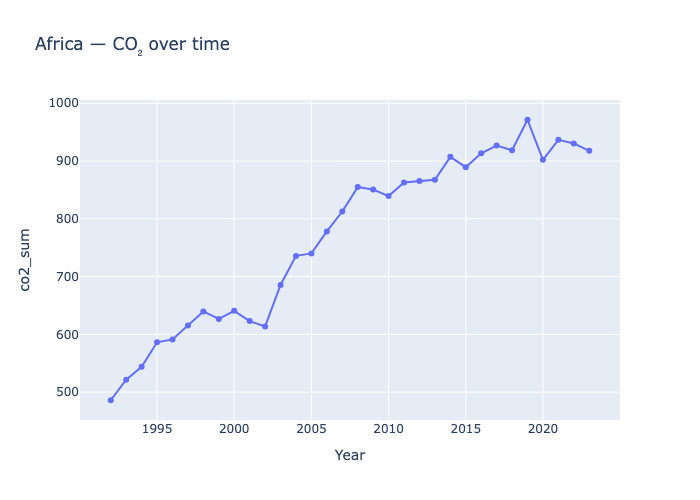

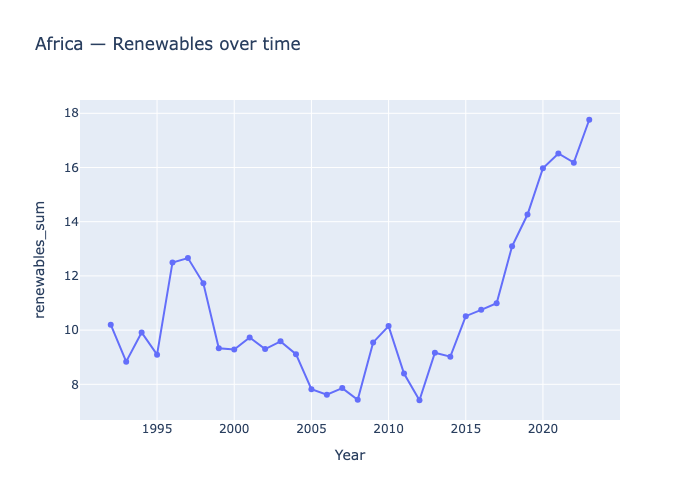

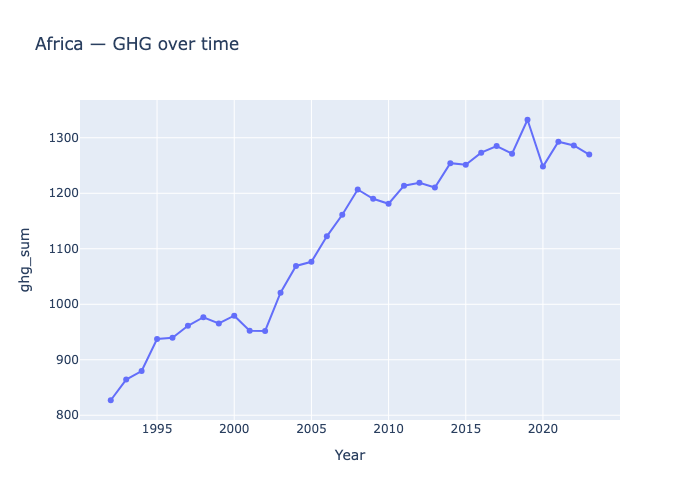

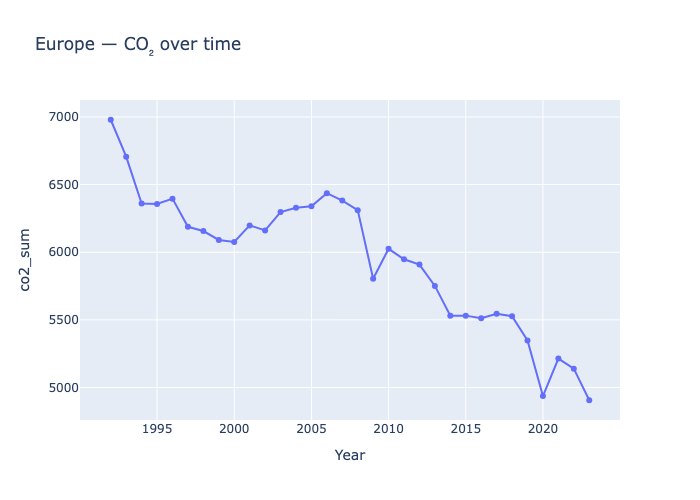

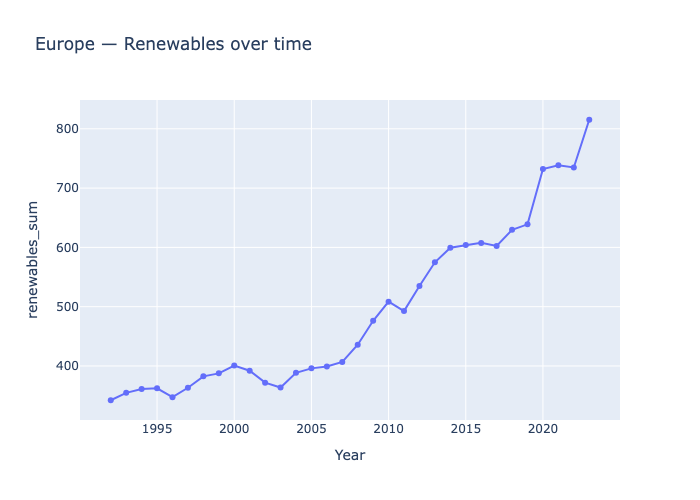

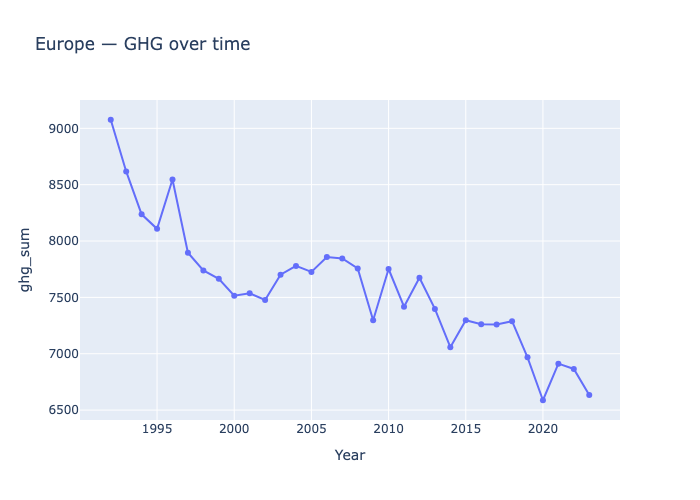

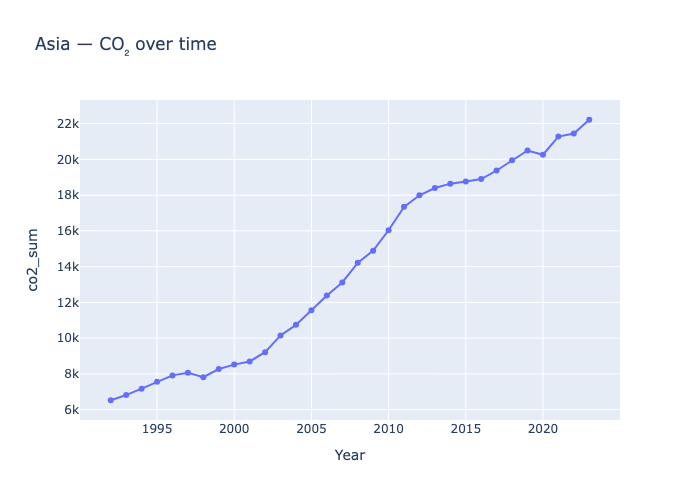

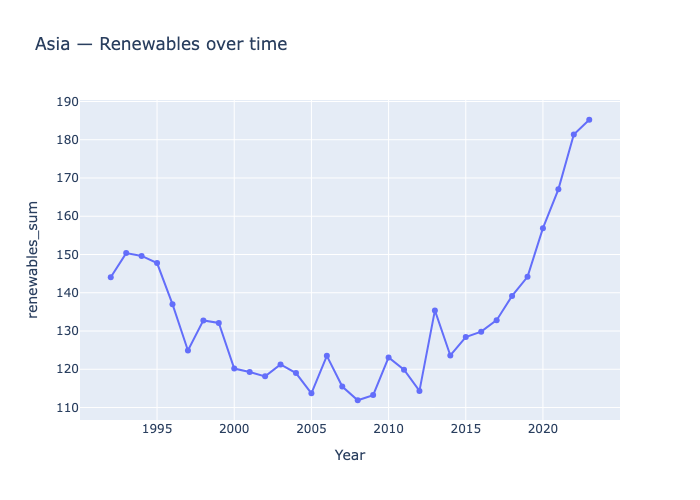

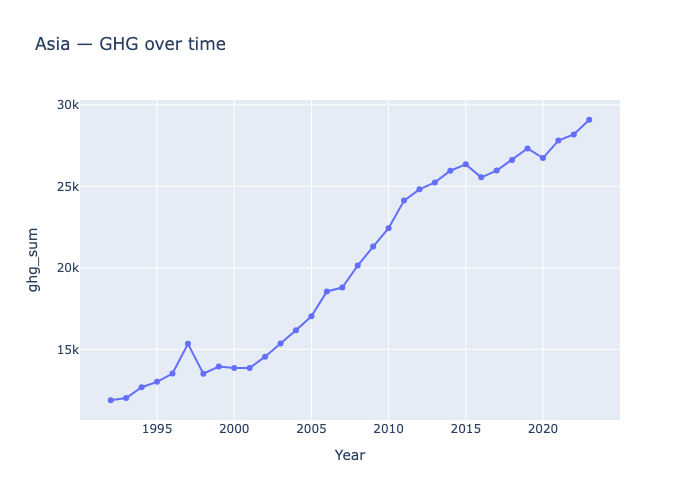

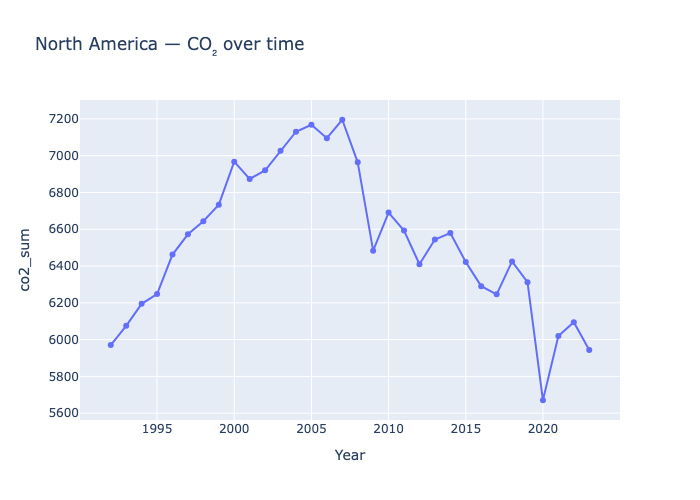

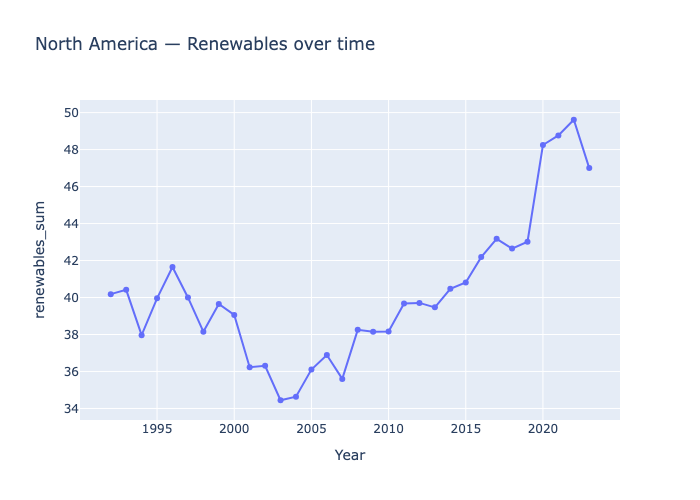

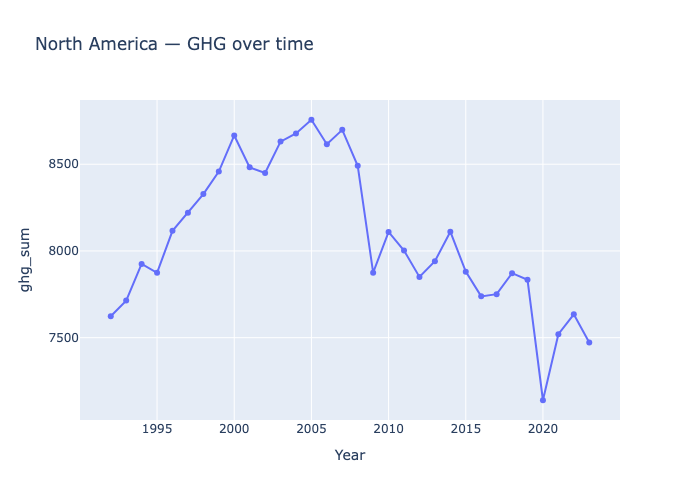

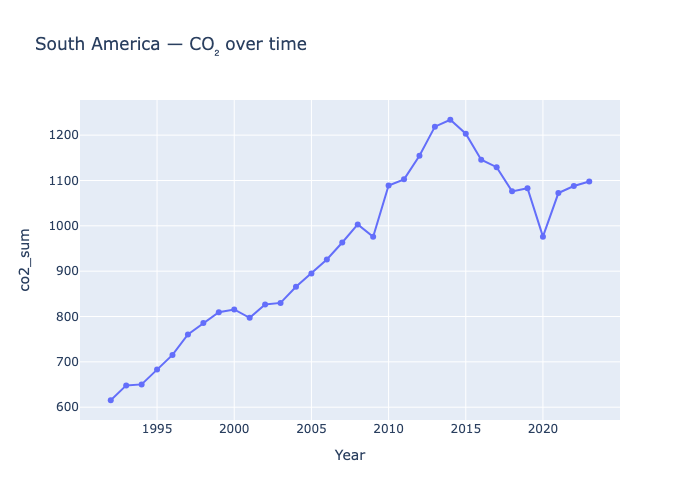

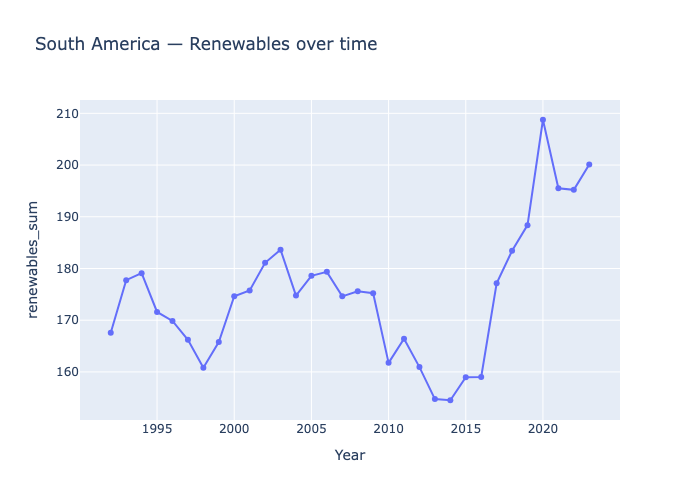

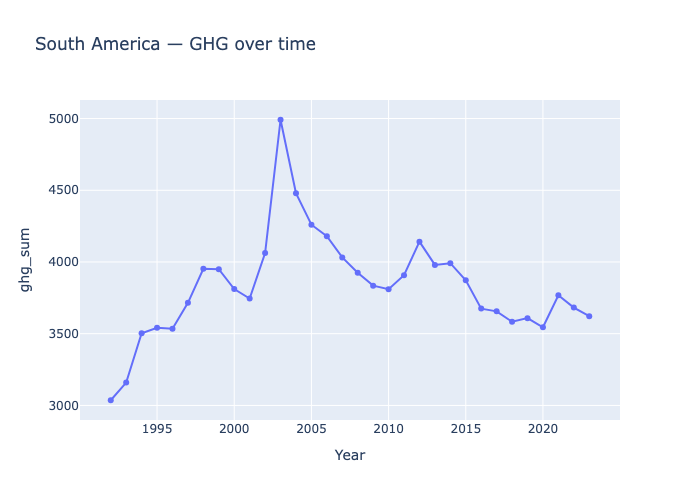

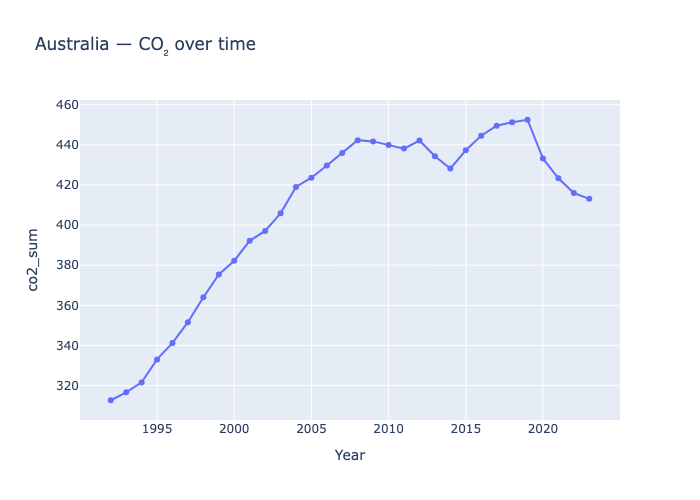

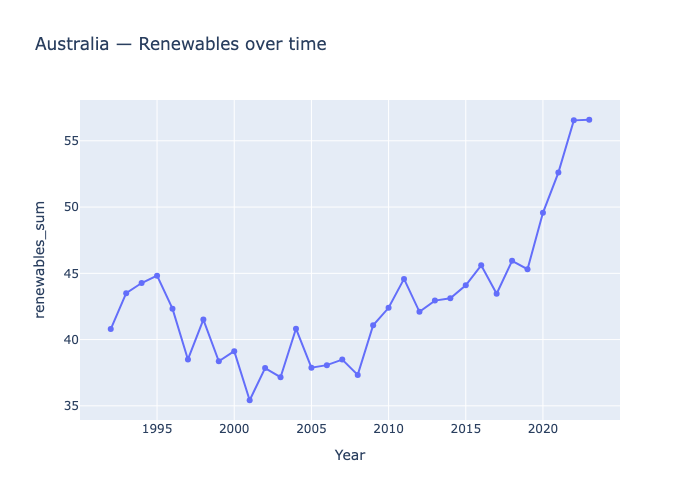

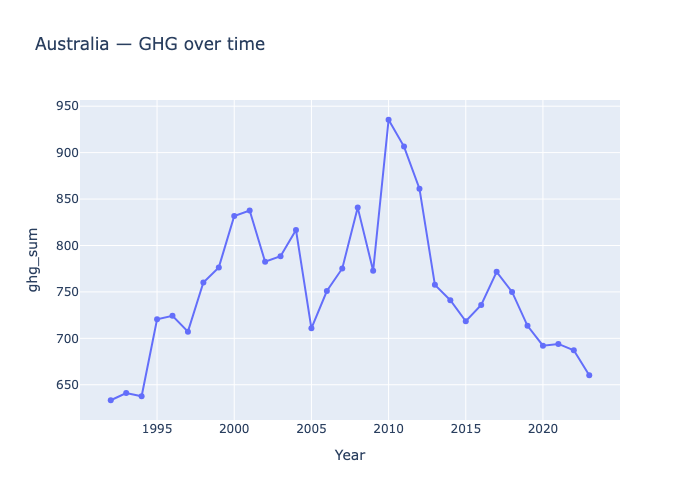

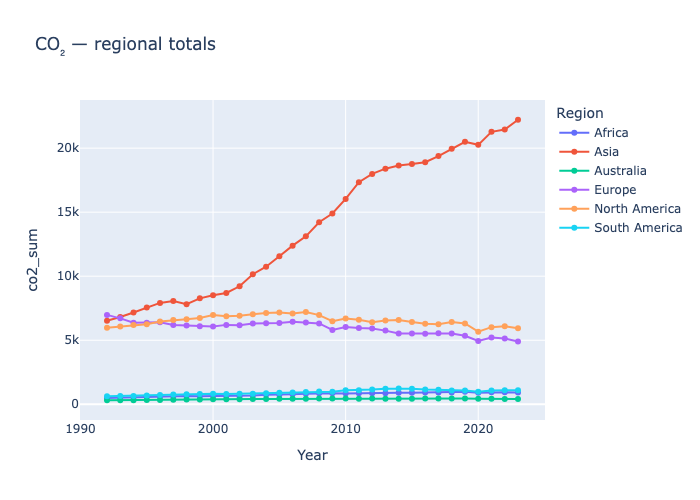

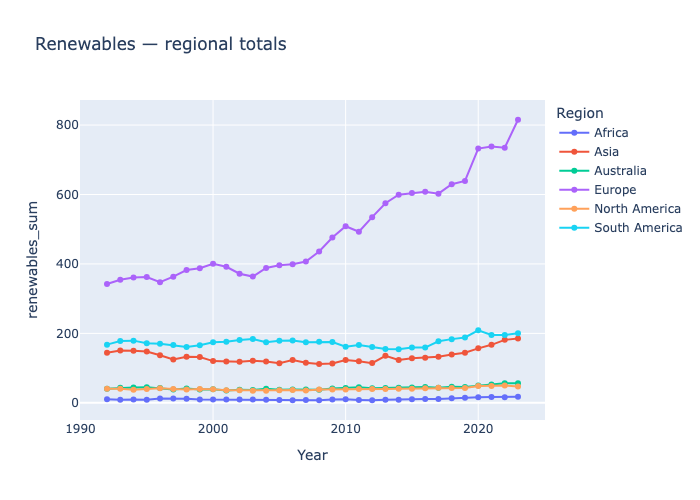

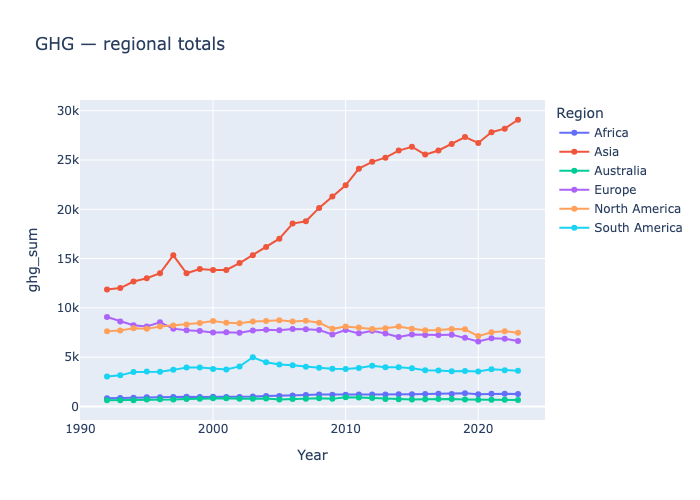

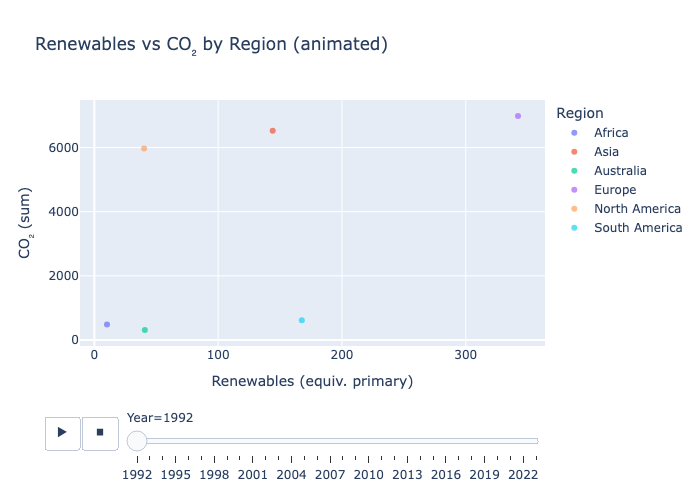

In [16]:
# 7.1 regional time series
for r in regions:
    g = by_region_year[by_region_year["Region"]==r]
    if g.empty:
        continue
    fig_co2 = px.line(g, x="Year", y="co2_sum", title=f"{r} — CO₂ over time", markers=True)
    fig_ren = px.line(g, x="Year", y="renewables_sum", title=f"{r} — Renewables over time", markers=True)
    fig_ghg = px.line(g, x="Year", y="ghg_sum", title=f"{r} — GHG over time", markers=True)
    fig_co2.show("png"); fig_ren.show("png"); fig_ghg.show("png")

# 7.2 cross-region comparison
fig_comp_co2 = px.line(by_region_year, x="Year", y="co2_sum", color="Region",
                       title="CO₂ — regional totals", markers=True)
fig_comp_ren = px.line(by_region_year, x="Year", y="renewables_sum", color="Region",
                       title="Renewables — regional totals", markers=True)
fig_comp_ghg = px.line(by_region_year, x="Year", y="ghg_sum", color="Region",
                       title="GHG — regional totals", markers=True)
fig_comp_co2.show("png"); fig_comp_ren.show("png"); fig_comp_ghg.show("png")

# 7.3 renewables vs CO2 scatter (animated by Year)
fig_scatter = px.scatter(by_region_year, x="renewables_sum", y="co2_sum",
                         color="Region", animation_frame="Year",
                         title="Renewables vs CO₂ by Region (animated)", opacity=0.7)
fig_scatter.update_layout(xaxis_title="Renewables (equiv. primary)", yaxis_title="CO₂ (sum)")
fig_scatter.show("png")

8) global rollups (world) — EDA & visuals

,Year,renewables_sum,co2_sum,ghg_sum,co2pc_avg
0,1992,744.997395,20886.752,33072.666,7.718406
1,1993,775.531717,21080.531,33005.724,7.674924
2,1994,781.927582,21241.517,33855.268,7.667623
3,1995,775.532782,21770.320,34187.243,7.691485
4,1996,750.712997,22421.046,35376.228,7.900804


,count,mean,std,min,25%,50%,75%,max
Year,32.0,2007.500000,9.380832,1992.000000,1999.750000,2007.500000,2015.250000,2023.000000
renewables_sum,32.0,894.297235,168.116794,744.997395,769.641603,795.363667,988.983516,1321.933405
co2_sum,32.0,28496.461437,5160.303142,20886.752000,23277.116000,29175.645500,33220.663000,35495.140000
ghg_sum,32.0,41411.972500,5479.010976,33005.724000,35731.857000,41787.963500,46592.697500,48740.460000
co2pc_avg,32.0,8.261762,0.466070,7.398452,7.855204,8.270864,8.692647,8.897497


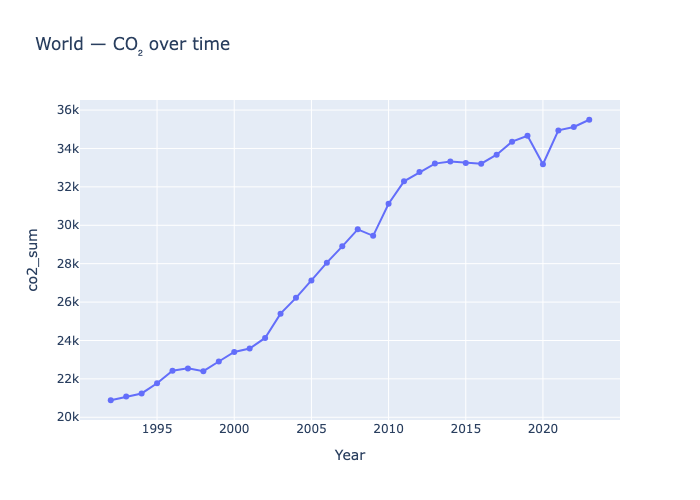

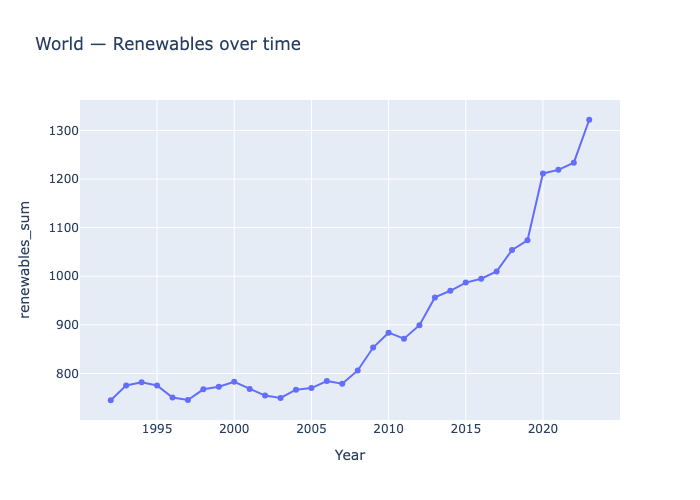

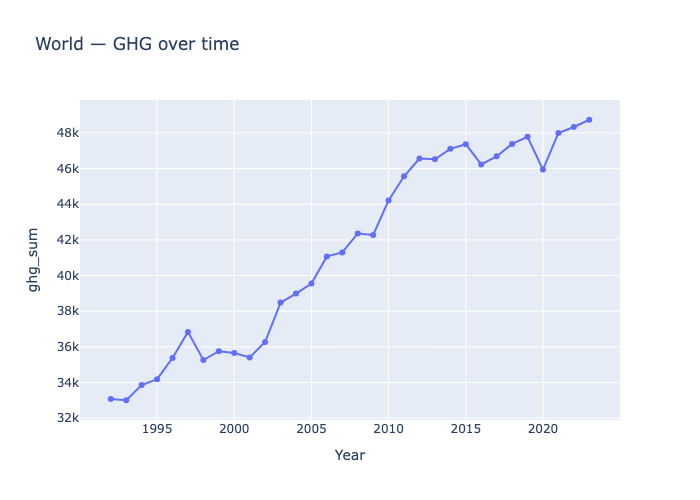

,renewables_sum,co2_sum,ghg_sum
renewables_sum,1.000000,0.830570,0.820665
co2_sum,0.830570,1.000000,0.995935
ghg_sum,0.820665,0.995935,1.000000


In [17]:
world = (by_region_year.groupby("Year")
         .agg(renewables_sum=("renewables_sum","sum"),
              co2_sum=("co2_sum","sum"),
              ghg_sum=("ghg_sum","sum"),
              co2pc_avg=("co2pc_avg","mean"))
         .reset_index())

display(world.head())
display(world.describe().T)

fig_w_co2 = px.line(world, x="Year", y="co2_sum", title="World — CO₂ over time", markers=True)
fig_w_ren = px.line(world, x="Year", y="renewables_sum", title="World — Renewables over time", markers=True)
fig_w_ghg = px.line(world, x="Year", y="ghg_sum", title="World — GHG over time", markers=True)
fig_w_co2.show("png"); fig_w_ren.show("png"); fig_w_ghg.show("png")

# simple world correlations
display(world[["renewables_sum","co2_sum","ghg_sum"]].corr())

9) forecasting helpers (SARIMAX with simple order search)

In [18]:
def fit_sarimax_forecast(series: pd.Series, steps:int=5):
    """
    Fits a simple SARIMAX with small grid search over (p,d,q) on a yearly series.
    Returns dict: order, aic, mean (pd.Series), ci (pd.DataFrame with lower/upper).
    """
    s = series.dropna().sort_index()
    if len(s) < 5:
        return {"order": None, "aic": None, "mean": None, "ci": None}
    p_vals, d_vals, q_vals = [0,1,2], [0,1], [0,1,2]
    best_aic = np.inf; best_order=None; best_fit=None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                try:
                    m = SARIMAX(s, order=(p,d,q),
                                enforce_stationarity=False, enforce_invertibility=False)
                    r = m.fit(disp=False)
                    if r.aic < best_aic:
                        best_aic, best_order, best_fit = r.aic, (p,d,q), r
                except Exception:
                    pass
    if best_fit is None:
        return {"order": None, "aic": None, "mean": None, "ci": None}
    fr = best_fit.get_forecast(steps=steps)
    mean = fr.predicted_mean
    ci = fr.conf_int(alpha=0.05)
    # normalize CI column names
    if isinstance(ci, pd.DataFrame) and ci.shape[1] == 2:
        ci.columns = ["lower","upper"]
    return {"order": best_order, "aic": float(best_aic), "mean": mean, "ci": ci}

10) regional forecasts (CO₂ & Renewables) + plots with CI

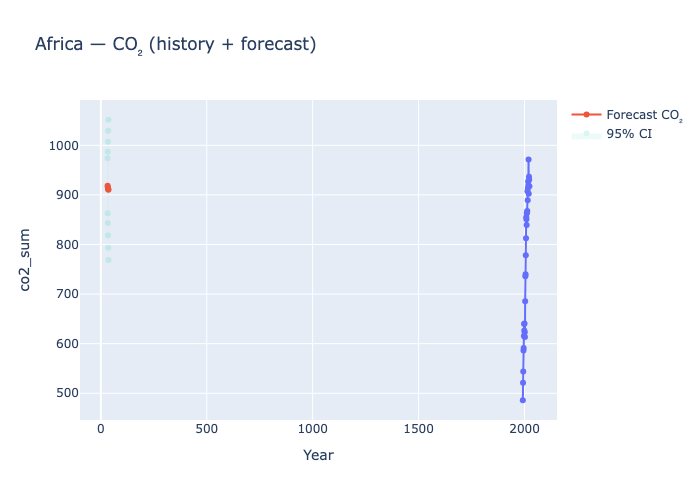

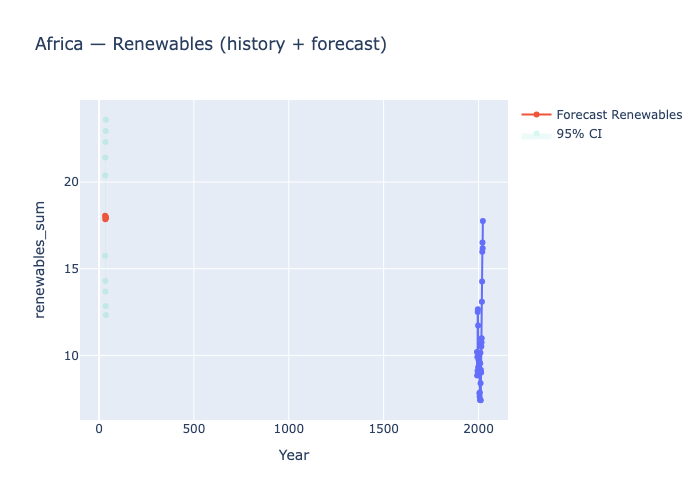

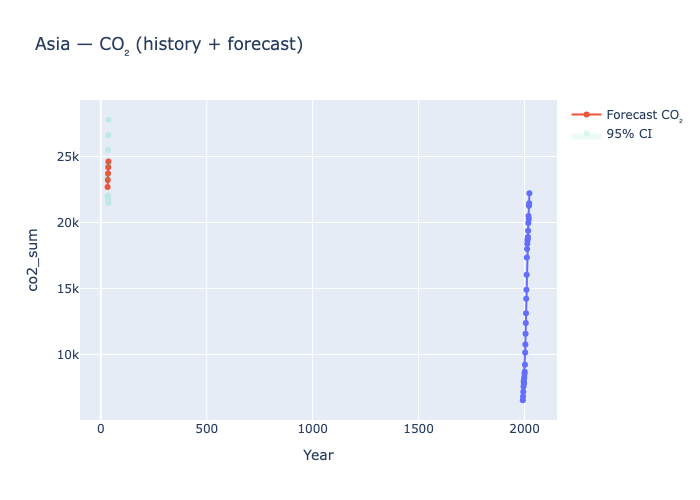

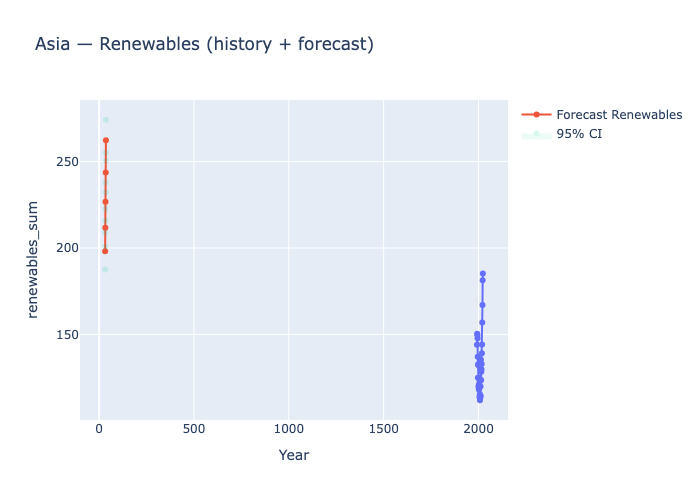

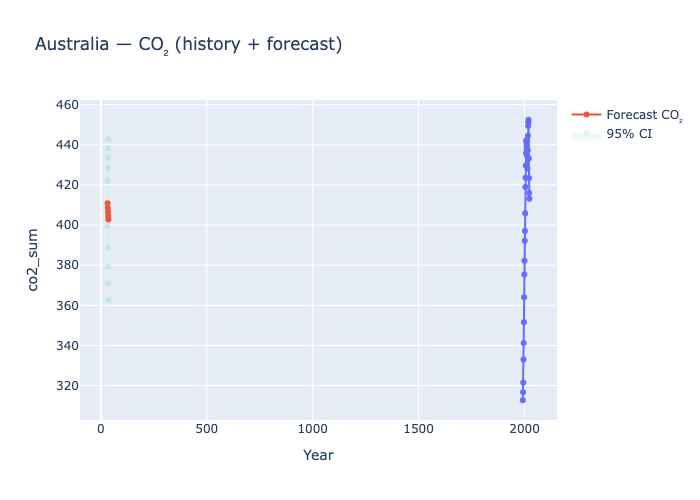

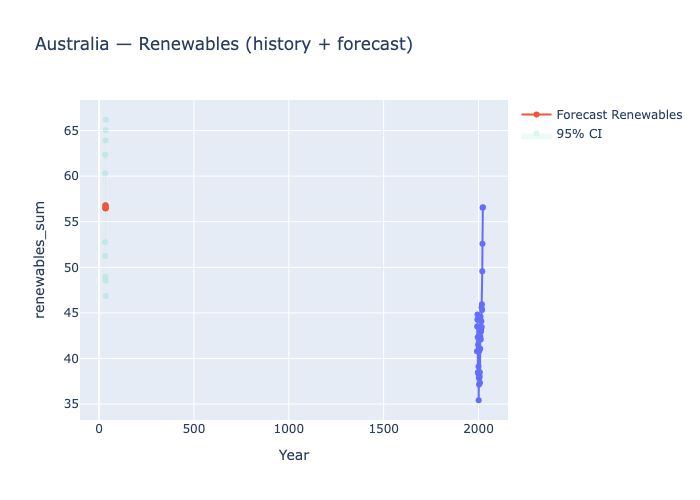

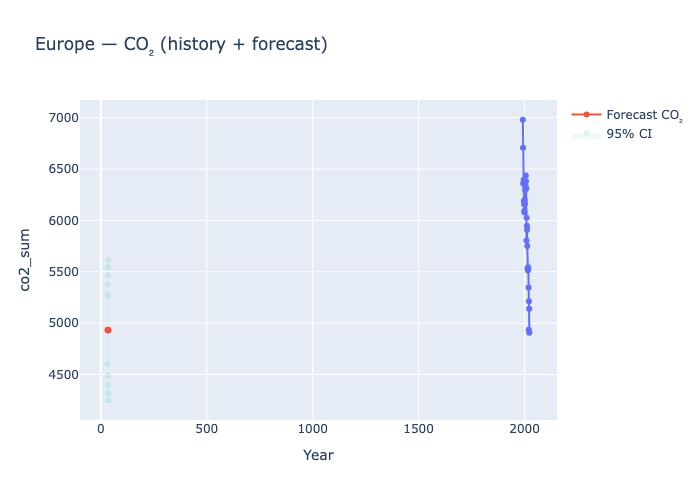

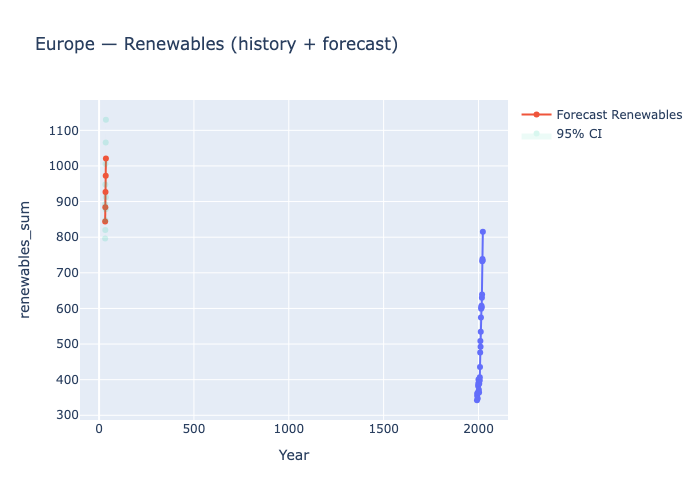

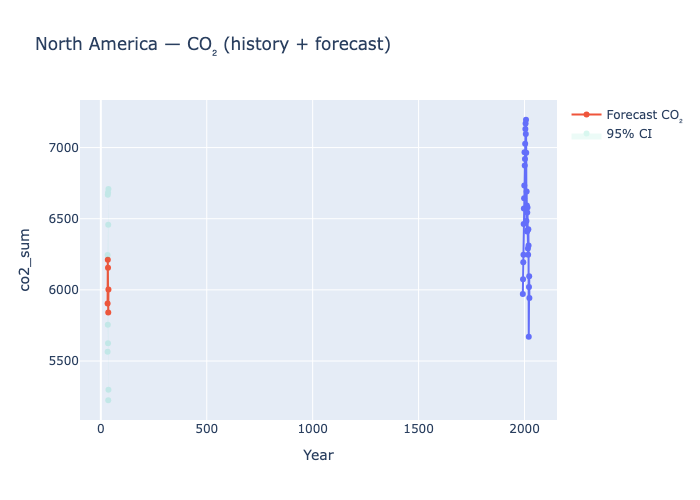

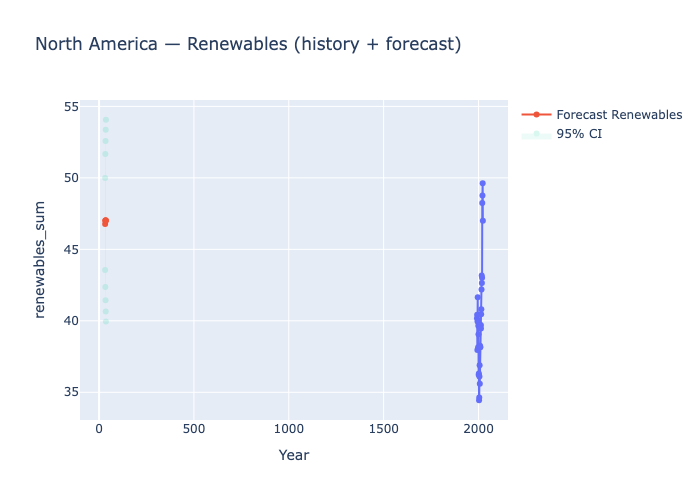

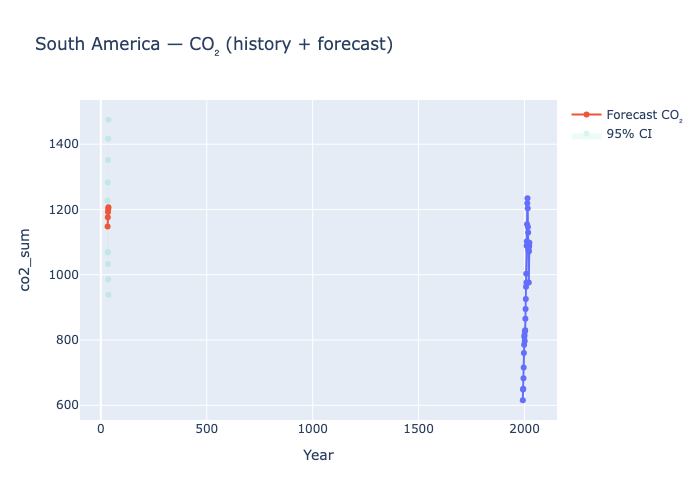

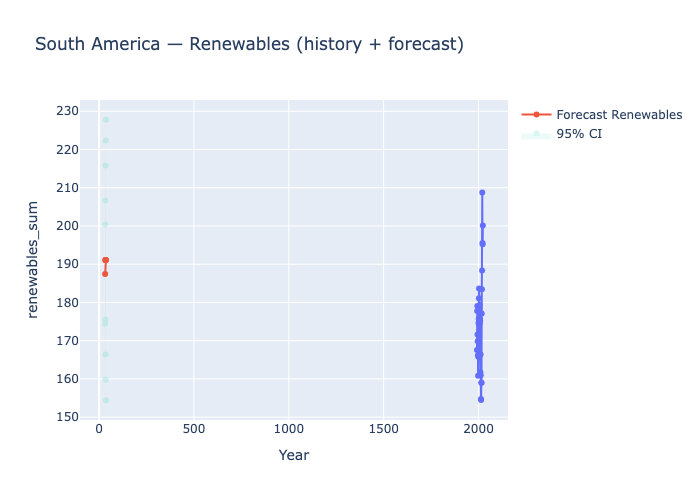

In [19]:
panel = by_region_year.set_index(["Region","Year"])[["co2_sum","renewables_sum"]]

pred_rows, model_rows = [], []
for region in panel.index.get_level_values(0).unique():
    sub = panel.loc[region].copy().sort_index()

    for metric in ["co2_sum","renewables_sum"]:
        res = fit_sarimax_forecast(sub[metric], steps=5)
        if res["mean"] is None:
            continue

        order, aic, mean, ci = res["order"], res["aic"], res["mean"], res["ci"]
        # collect preds
        for year, val in mean.items():
            lower = float(ci.loc[year, "lower"]) if isinstance(ci, pd.DataFrame) and "lower" in ci.columns else np.nan
            upper = float(ci.loc[year, "upper"]) if isinstance(ci, pd.DataFrame) and "upper" in ci.columns else np.nan
            pred_rows.append({"Scope":"Region","Region":region,"Metric":metric,
                              "Year":int(year),"pred":float(val),"lower":lower,"upper":upper,
                              "order": str(order) if order else None})
        model_rows.append({"Scope":"Region","Region":region,"Metric":metric,
                           "order": str(order) if order else None, "aic": aic})

# plot examples & save htmls
for region in panel.index.get_level_values(0).unique():
    hist = panel.loc[region].reset_index()
    # CO2
    fig = px.line(hist, x="Year", y="co2_sum", title=f"{region} — CO₂ (history + forecast)", markers=True)
    fut = pd.DataFrame([r for r in pred_rows if r["Region"]==region and r["Metric"]=="co2_sum"])
    if not fut.empty:
        fig.add_trace(go.Scatter(x=fut["Year"], y=fut["pred"], mode="lines+markers", name="Forecast CO₂"))
        # CI band
        if "lower" in fut and "upper" in fut:
            x = list(fut["Year"]) + list(fut["Year"][::-1])
            y = list(fut["upper"]) + list(fut["lower"][::-1])
            fig.add_trace(go.Scatter(x=x, y=y, fill="toself", opacity=0.15, line=dict(width=0), name="95% CI"))
    fig.show("png")

    # Renewables
    fig2 = px.line(hist, x="Year", y="renewables_sum", title=f"{region} — Renewables (history + forecast)", markers=True)
    fut2 = pd.DataFrame([r for r in pred_rows if r["Region"]==region and r["Metric"]=="renewables_sum"])
    if not fut2.empty:
        fig2.add_trace(go.Scatter(x=fut2["Year"], y=fut2["pred"], mode="lines+markers", name="Forecast Renewables"))
        if "lower" in fut2 and "upper" in fut2:
            x = list(fut2["Year"]) + list(fut2["Year"][::-1])
            y = list(fut2["upper"]) + list(fut2["lower"][::-1])
            fig2.add_trace(go.Scatter(x=x, y=y, fill="toself", opacity=0.15, line=dict(width=0), name="95% CI"))
    fig2.show("png")

11) global forecasts (CO₂ & Renewables) + plots with CI

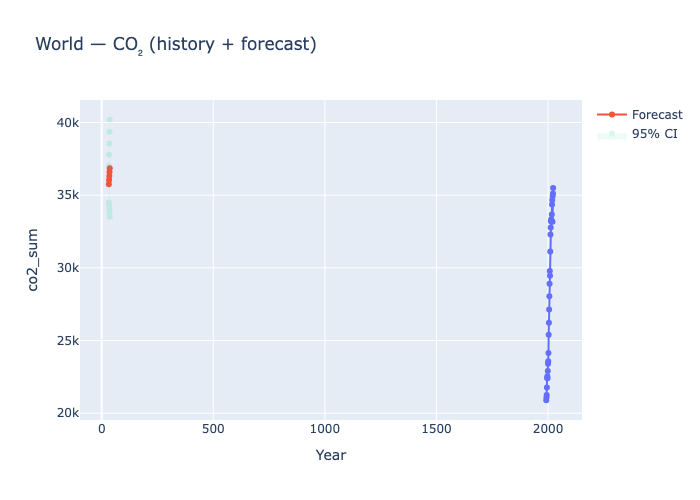

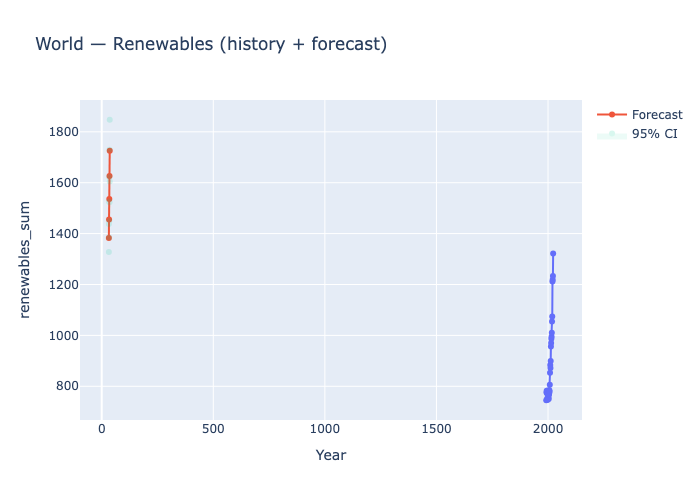

In [20]:
world_idx = world.set_index("Year")[["co2_sum","renewables_sum"]]

pred_rows_glob, model_rows_glob = [], []
for metric in ["co2_sum","renewables_sum"]:
    res = fit_sarimax_forecast(world_idx[metric], steps=5)
    if res["mean"] is None:
        continue
    order, aic, mean, ci = res["order"], res["aic"], res["mean"], res["ci"]
    for year, val in mean.items():
        lower = float(ci.loc[year, "lower"]) if isinstance(ci, pd.DataFrame) and "lower" in ci.columns else np.nan
        upper = float(ci.loc[year, "upper"]) if isinstance(ci, pd.DataFrame) and "upper" in ci.columns else np.nan
        pred_rows_glob.append({"Scope":"Global","Region":"World","Metric":metric,
                               "Year":int(year),"pred":float(val),"lower":lower,"upper":upper,
                               "order": str(order) if order else None})
    model_rows_glob.append({"Scope":"Global","Region":"World","Metric":metric,
                            "order": str(order) if order else None, "aic": aic})

# plot
for metric, title in [("co2_sum","World — CO₂ (history + forecast)"),
                      ("renewables_sum","World — Renewables (history + forecast)")]:
    hist = world.copy()
    fig = px.line(hist, x="Year", y=metric, title=title, markers=True)
    fut = pd.DataFrame([r for r in pred_rows_glob if r["Metric"]==metric])
    if not fut.empty:
        fig.add_trace(go.Scatter(x=fut["Year"], y=fut["pred"], mode="lines+markers", name="Forecast"))
        if "lower" in fut and "upper" in fut:
            x = list(fut["Year"]) + list(fut["Year"][::-1])
            y = list(fut["upper"]) + list(fut["lower"][::-1])
            fig.add_trace(go.Scatter(x=x, y=y, fill="toself", opacity=0.15, line=dict(width=0), name="95% CI"))
    fig.show("png")


12) export artifacts (predictions & models)

In [21]:
pred_df = pd.DataFrame(pred_rows + pred_rows_glob)
models_df = pd.DataFrame(model_rows + model_rows_glob)

pred_path = os.path.join(OUTDIR, "predictions_sarimax_region_global.csv")
models_path = os.path.join(OUTDIR, "models_sarimax_region_global.csv")

pred_df.to_csv(pred_path, index=False)
models_df.to_csv(models_path, index=False)
print("Saved:", os.path.abspath(pred_path))
print("Saved:", os.path.abspath(models_path))
display(pred_df.head())
display(models_df.head())

Saved: /Users/chiagoziemcyriacusugoh/predictions_sarimax_region_global.csv
Saved: /Users/chiagoziemcyriacusugoh/models_sarimax_region_global.csv


,Scope,Region,Metric,Year,pred,lower,upper,order
0,Region,Africa,co2_sum,32,918.426825,863.116783,973.736868,"(1, 1, 2)"
1,Region,Africa,co2_sum,33,915.244507,843.251539,987.237475,"(1, 1, 2)"
2,Region,Africa,co2_sum,34,912.990564,818.895544,1007.085583,"(1, 1, 2)"
3,Region,Africa,co2_sum,35,911.394162,793.601876,1029.186448,"(1, 1, 2)"
4,Region,Africa,co2_sum,36,910.263477,768.912160,1051.614794,"(1, 1, 2)"


,Scope,Region,Metric,order,aic
0,Region,Africa,co2_sum,"(1, 1, 2)",274.680800
1,Region,Africa,renewables_sum,"(1, 1, 1)",98.654216
2,Region,Asia,co2_sum,"(1, 1, 2)",417.746380
3,Region,Asia,renewables_sum,"(2, 0, 2)",197.044106
4,Region,Australia,co2_sum,"(1, 1, 2)",185.409058


13) Extra ML: simple regression of CO₂ ~ Renewables + lags (global)

In [22]:
# quick illustrative regression
ml_world = world_idx.copy().reset_index()
for lag in [1,2]:
    ml_world[f"renewables_sum_lag{lag}"] = ml_world["renewables_sum"].shift(lag)
ml_world = ml_world.dropna().copy()

import statsmodels.api as sm
X = ml_world[["renewables_sum","renewables_sum_lag1","renewables_sum_lag2"]]
X = sm.add_constant(X)
y = ml_world["co2_sum"]
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                co2_sum   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     19.54
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           7.69e-07
Time:                        21:14:06   Log-Likelihood:                -279.46
No. Observations:                  30   AIC:                             566.9
Df Residuals:                      26   BIC:                             572.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7690.0626   3

14) insights & takeaways (printed summaries)

In [23]:
def quick_takeaways(by_region_year, world):
    notes = []
    # correlation signal by region
    for r, g in by_region_year.groupby("Region"):
        g = g.dropna(subset=["renewables_sum","co2_sum"])
        if len(g) < 3: 
            continue
        corr = g["renewables_sum"].corr(g["co2_sum"])
        notes.append((r, corr))
    notes = sorted(notes, key=lambda x: (pd.isna(x[1]), x[1]))
    print("Correlation (renewables_sum vs co2_sum) by region:")
    for r, c in notes:
        print(f"  {r:15s} : {c: .3f}")

    print("\nGlobal correlation (renewables vs CO2, GHG):")
    print(world[["renewables_sum","co2_sum","ghg_sum"]].corr())

quick_takeaways(by_region_year, world)

Correlation (renewables_sum vs co2_sum) by region:
  Europe          : -0.949
  North America   : -0.816
  South America   : -0.076
  Australia       :  0.141
  Asia            :  0.336
  Africa          :  0.352

Global correlation (renewables vs CO2, GHG):
                renewables_sum   co2_sum   ghg_sum
renewables_sum        1.000000  0.830570  0.820665
co2_sum               0.830570  1.000000  0.995935
ghg_sum               0.820665  0.995935  1.000000


15) streamlit dashboard (plotly + sqlite + sarimax)

In [24]:
app_code = r'''
import os, sqlite3, warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
st.set_page_config(layout="wide", page_title="Emissions & Renewables — Global Insights")

# ---- Sidebar framing ----
st.sidebar.title("🌍 Emissions & Renewables")
st.sidebar.write("""
Flip the lens to **renewables and emissions** to see how adoption relates to **CO₂ / GHG**.
Use this to inform **policy**, **ESG**, and **forecasting**.
""")

DEFAULT_CSV_PATH = os.environ.get("EMISSIONS_CSV", "Copy1-Emissions_Renewables_Merged.csv")
csv_path = st.sidebar.text_input("CSV path", value=DEFAULT_CSV_PATH)
uploaded = st.sidebar.file_uploader("...or upload CSV", type=["csv"])

@st.cache_data
def load_raw(csv_path, uploaded_file):
    if uploaded_file is not None:
        df = pd.read_csv(uploaded_file)
    else:
        df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={"co2":"CO2","co2_per_capita":"CO2_per_capita","total_ghg":"Total_GHG"})
    return df

@st.cache_data
def clean_and_engineer(df):
    for col in ["Renewables_equivalent_primary_energy","CO2","CO2_per_capita","Total_GHG","Year"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["Country","Year","CO2"]).copy()
    df["Renewables_equivalent_primary_energy"] = df["Renewables_equivalent_primary_energy"].fillna(0)
    df["Total_GHG"] = df["Total_GHG"].fillna(df["CO2"])
    for col in ["Renewables_equivalent_primary_energy","CO2","CO2_per_capita","Total_GHG"]:
        if col in df.columns:
            df.loc[df[col] < 0, col] = np.nan
    df = df.sort_values(["Country","Year"]).reset_index(drop=True)
    cols = [c for c in ["CO2","CO2_per_capita","Total_GHG","Renewables_equivalent_primary_energy"] if c in df.columns]
    if cols:
        df[cols] = df.groupby("Country")[cols].transform(lambda g: g.ffill().bfill())
    df["Renewables_grow_yoy"] = df.groupby("Country")["Renewables_equivalent_primary_energy"].pct_change()
    df["CO2_grow_yoy"] = df.groupby("Country")["CO2"].pct_change()
    df["CO2_per_renewable_unit"] = df["CO2"] / df["Renewables_equivalent_primary_energy"].replace(0, np.nan)
    return df

@st.cache_data
def map_regions(df):
    UN_TO_SUBREG = {
        'Algeria':'Northern Africa','Argentina':'South America','Australia':'Australia and New Zealand','Austria':'Western Europe',
        'Azerbaijan':'Western Asia','Bangladesh':'Southern Asia','Belarus':'Eastern Europe','Belgium':'Western Europe','Brazil':'South America',
        'Bulgaria':'Eastern Europe','Canada':'Northern America','Chile':'South America','China':'Eastern Asia','Colombia':'South America',
        'Croatia':'Southern Europe','Cyprus':'Southern Europe','Czechia':'Eastern Europe','Denmark':'Northern Europe','Ecuador':'South America',
        'Egypt':'Northern Africa','Estonia':'Northern Europe','Finland':'Northern Europe','France':'Western Europe','Germany':'Western Europe',
        'Greece':'Southern Europe','Hong Kong':'Eastern Asia','Hungary':'Eastern Europe','Iceland':'Northern Europe','India':'Southern Asia',
        'Indonesia':'South-eastern Asia','Iran':'Southern Asia','Iraq':'Western Asia','Ireland':'Northern Europe','Israel':'Western Asia',
        'Italy':'Southern Europe','Japan':'Eastern Asia','Kazakhstan':'Central Asia','Kuwait':'Western Asia','Latvia':'Northern Europe',
        'Lithuania':'Northern Europe','Luxembourg':'Western Europe','Malaysia':'South-eastern Asia','Mexico':'Central America',
        'Morocco':'Northern Africa','Netherlands':'Western Europe','New Zealand':'Australia and New Zealand','North Macedonia':'Southern Europe',
        'Norway':'Northern Europe','Oman':'Western Asia','Pakistan':'Southern Asia','Peru':'South America','Philippines':'South-eastern Asia',
        'Poland':'Eastern Europe','Portugal':'Southern Europe','Qatar':'Western Asia','Romania':'Eastern Europe','Russia':'Eastern Europe',
        'Saudi Arabia':'Western Asia','Singapore':'South-eastern Asia','Slovakia':'Eastern Europe','Slovenia':'Southern Europe',
        'South Africa':'Southern Africa','South Korea':'Eastern Asia','Spain':'Southern Europe','Sri Lanka':'Southern Asia','Sweden':'Northern Europe',
        'Switzerland':'Western Europe','Taiwan':'Eastern Asia','Thailand':'South-eastern Asia','Trinidad and Tobago':'Latin America and the Caribbean',
        'Turkey':'Western Asia','Turkmenistan':'Central Asia','Ukraine':'Eastern Europe','United Arab Emirates':'Western Asia',
        'United Kingdom':'Northern Europe','United States':'Northern America','Uzbekistan':'Central Asia','Venezuela':'South America','Vietnam':'South-eastern Asia'
    }
    SUBREG_TO_REGION = {
        'Northern Africa':'Africa','Southern Africa':'Africa','Middle Africa':'Africa','Western Africa':'Africa','Eastern Africa':'Africa',
        'Southern Europe':'Europe','Northern Europe':'Europe','Western Europe':'Europe','Eastern Europe':'Europe',
        'Central Asia':'Asia','Eastern Asia':'Asia','South-eastern Asia':'Asia','Southern Asia':'Asia','Western Asia':'Asia',
        'Central America':'North America','Northern America':'North America',
        'South America':'South America','Latin America and the Caribbean':'South America',
        'Australia and New Zealand':'Australia','Oceania':'Australia','Other':'Other'
    }
    df = df.copy()
    df["UN_Region"] = df["Country"].map(UN_TO_SUBREG).fillna("Other")
    df["Region_Canonical"] = df["UN_Region"].map(SUBREG_TO_REGION).fillna("Other")
    return df

def build_sqlite(df):
    conn = sqlite3.connect(":memory:")
    df.to_sql("emissions", conn, index=False, if_exists="replace")
    return conn

def fit_sarimax(series, steps=5):
    s = series.dropna().sort_index()
    if len(s) < 5:
        return None
    best = None; best_aic = float("inf"); best_order = None
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                try:
                    m = SARIMAX(s, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                    r = m.fit(disp=False)
                    if r.aic < best_aic:
                        best, best_aic, best_order = r, r.aic, (p,d,q)
                except Exception:
                    pass
    if best is None: return None
    fr = best.get_forecast(steps=steps)
    mean = fr.predicted_mean
    ci = fr.conf_int(alpha=0.05)
    ci.columns = ["lower","upper"] if ci.shape[1]==2 else ci.columns
    return {"order":best_order, "aic":float(best_aic), "mean":mean, "ci":ci}

# ---- pipeline ----
raw = load_raw(csv_path, uploaded)
clean = clean_and_engineer(raw)
clean = map_regions(clean)
conn = build_sqlite(clean)

reg = pd.read_sql("""
SELECT Region_Canonical AS Region, Year,
       SUM(Renewables_equivalent_primary_energy) AS renewables_sum,
       SUM(CO2) AS co2_sum,
       SUM(Total_GHG) AS ghg_sum,
       AVG(CO2_per_capita) AS co2pc_avg
FROM emissions
GROUP BY Region, Year
ORDER BY Region, Year
""", conn)

tab1, tab2, tab3 = st.tabs(["📊 EDA", "🔮 Forecasting", "📂 Data"])

with tab1:
    st.subheader("Exploratory Data Analysis")
    regions_list = ["Global","Africa","Europe","Asia","North America","South America","Australia"]
    c1, c2 = st.columns(2)
    with c1:
        rsel = st.selectbox("Region", regions_list, index=0)
    with c2:
        msel = st.selectbox("Metric", ["CO₂ (sum)","Renewables (sum)","Total GHG (sum)","CO₂ per capita (avg)"], index=0)
    col_map = {"CO₂ (sum)":"co2_sum","Renewables (sum)":"renewables_sum",
               "Total GHG (sum)":"ghg_sum","CO₂ per capita (avg)":"co2pc_avg"}
    mcol = col_map[msel]

    if rsel == "Global":
        gp = (reg.groupby("Year")
                .agg(renewables_sum=("renewables_sum","sum"),
                     co2_sum=("co2_sum","sum"),
                     ghg_sum=("ghg_sum","sum"),
                     co2pc_avg=("co2pc_avg","mean"))
                .reset_index())
    else:
        gp = reg[reg["Region"]==rsel].copy()

    fig = px.line(gp, x="Year", y=mcol, title=f"{rsel} — {msel}", markers=True)
    st.plotly_chart(fig, use_container_width=True)
    st.dataframe(gp.describe().T)

    st.markdown("---")
    st.markdown("**Custom SQL (table: `emissions`)**")
    default_sql = "SELECT Region_Canonical, Year, SUM(CO2) AS co2_sum FROM emissions GROUP BY Region_Canonical, Year LIMIT 50;"
    q = st.text_area("SQL", value=default_sql, height=120)
    if st.button("Run SQL"):
        try:
            res = pd.read_sql(q, conn)
            st.dataframe(res)
        except Exception as e:
            st.error(str(e))

with tab2:
    st.subheader("Forecasting (SARIMAX, 5y)")
    c1, c2, c3 = st.columns(3)
    with c1:
        rsel = st.selectbox("Region", ["Global","Africa","Europe","Asia","North America","South America","Australia"], index=0, key="f_r")
    with c2:
        msel = st.selectbox("Metric", ["CO₂ (sum)","Renewables (sum)"], index=0, key="f_m")
    with c3:
        view = st.selectbox("Show", ["Both","Historical only","Forecast only"], index=0)

    mcol = "co2_sum" if "CO₂" in msel else "renewables_sum"
    if rsel == "Global":
        hist = (reg.groupby("Year")
                .agg(co2_sum=("co2_sum","sum"),
                     renewables_sum=("renewables_sum","sum"))
                .reset_index())
        series = hist.set_index("Year")[mcol]
        title = "World"
    else:
        hist = reg[reg["Region"]==rsel].copy()
        series = hist.set_index("Year")[mcol]
        title = rsel

    res = fit_sarimax(series, steps=5)
    fig = go.Figure()
    if view in ["Both","Historical only"]:
        fig.add_trace(go.Scatter(x=hist["Year"], y=hist[mcol], mode="lines+markers", name="Historical"))
    if res is not None and view in ["Both","Forecast only"]:
        mean, ci = res["mean"], res["ci"]
        fig.add_trace(go.Scatter(x=mean.index, y=mean.values, mode="lines+markers", name="Forecast"))
        if ci is not None and "lower" in ci.columns and "upper" in ci.columns:
            fig.add_trace(go.Scatter(
                x=list(mean.index)+list(mean.index[::-1]),
                y=list(ci["upper"].values)+list(ci["lower"].values[::-1]),
                fill="toself", opacity=0.2, line=dict(width=0), name="95% CI"
            ))
        st.caption(f"Best SARIMAX order: {res['order']} | AIC: {round(res['aic'],2)}")
        ftab = pd.DataFrame({"Year": mean.index, "Forecast": mean.values,
                             "Lower_95": ci["lower"].values if "lower" in ci.columns else np.nan,
                             "Upper_95": ci["upper"].values if "upper" in ci.columns else np.nan})
        st.dataframe(ftab)

    fig.update_layout(title=f"{title} — {msel}")
    st.plotly_chart(fig, use_container_width=True)

with tab3:
    st.subheader("Data")
    st.dataframe(clean.head(500))
    csv = clean.to_csv(index=False).encode("utf-8")
    st.download_button("Download cleaned CSV", data=csv, file_name="cleaned_emissions_renewables.csv", mime="text/csv")
'''
# write file
with open("streamlit_app.py","w") as f:
    f.write(app_code)

print("Wrote streamlit_app.py → run with:  streamlit run streamlit_app.py")

Wrote streamlit_app.py → run with:  streamlit run streamlit_app.py


16) requirements & deployment helpers

In [25]:
# Write helper files
req = """streamlit==1.38.0
pandas==2.2.2
numpy==1.26.4
plotly==5.23.0
statsmodels==0.14.2
scikit-learn==1.5.1
sqlite3-binary==0.0.1
"""
with open("requirements.txt","w") as f: f.write(req)

proc = "web: streamlit run streamlit_app.py --server.port=$PORT --server.address=0.0.0.0\n"
with open("Procfile","w") as f: f.write(proc)

app_yaml = """sdk: streamlit
sdk_version: 1.38.0
app_file: streamlit_app.py
python_version: 3.12
"""
with open("app.yaml","w") as f: f.write(app_yaml)

print("Wrote requirements.txt, Procfile, app.yaml")

Wrote requirements.txt, Procfile, app.yaml


In [26]:
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# --------------------------
# Aggregation helper
# --------------------------

PLOT_CONFIG = {
    'height': 1000,
    'width': 1500,
    'config': {'displayModeBar': True, 'displaylogo': False}
}

def aggregate_data(region=None, country=None):
    """Aggregate emissions/renewables data by Global, Region, or Country."""
    if region == "Global":
        df_f = df.groupby("Year", as_index=False).agg({
            "CO2":"sum",
            "Renewables_equivalent_primary_energy":"sum",
            "Total_GHG":"sum",
            "CO2_per_capita":"mean"
        })
        df_f["Label"] = "Global"
    elif country and country != "All":
        df_f = df[df["Country"] == country].groupby("Year", as_index=False).agg({
            "CO2":"sum",
            "Renewables_equivalent_primary_energy":"sum",
            "Total_GHG":"sum",
            "CO2_per_capita":"mean"
        })
        df_f["Label"] = f"{region} - {country}"
    else: # Region-level
        df_f = df[df["Region_Canonical"] == region].groupby("Year", as_index=False).agg({
            "CO2":"sum",
            "Renewables_equivalent_primary_energy":"sum",
            "Total_GHG":"sum",
            "CO2_per_capita":"mean"
        })
        df_f["Label"] = f"{region} - All"
    return df_f

# --------------------------
# Widgets
# --------------------------
regions = ["Global"] + sorted(df["Region_Canonical"].dropna().unique().tolist())
region_dropdown = widgets.Dropdown(
    options=regions,
    value="Global",
    description="Region:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="300px")
)

country_dropdown = widgets.Dropdown(
    options=["All"],
    value="All",
    description="Country:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="300px")
)

# --------------------------
# Function to update country list
# --------------------------
def update_countries(*args):
    selected_region = region_dropdown.value
    if selected_region == "Global":
        country_dropdown.options = ["All"]
        country_dropdown.value = "All"
    else:
        countries = sorted(df[df["Region_Canonical"] == selected_region]["Country"].unique())
        country_dropdown.options = ["All"] + countries
        country_dropdown.value = "All"

region_dropdown.observe(update_countries, names="value")
update_countries()

# --------------------------
# Function to plot
# --------------------------
def update_plot(region, country):
    df_filtered = aggregate_data(region, country if country != "All" else None)
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("CO₂ Emissions (Mt)",
                       "Renewables (Primary Energy Eq.)",
                       "Total GHG (Mt CO₂eq)",
                       "CO₂ per Capita (tons)")
    )
    
    trace_names = ["CO2", "Renewables_equivalent_primary_energy", "Total_GHG", "CO2_per_capita"]
    for i, col in enumerate(trace_names, 1):
        row, colpos = divmod(i-1, 2)
        fig.add_trace(go.Scatter(x=df_filtered["Year"], y=df_filtered[col],
                                mode="lines+markers", name=col),
                     row=row+1, col=colpos+1)
    
    fig.update_layout(
        title=f"Emissions & Renewables Dashboard: {df_filtered['Label'].iloc[0]}",
        height=PLOT_CONFIG['height'],
        width=PLOT_CONFIG['width'],
        showlegend=False
    )
    
    for ax in ["xaxis","xaxis2","xaxis3","xaxis4"]:
        fig.update_layout({ax: dict(rangeslider=dict(visible=True))})
    
    fig.write_image("filename.png")
    fig.show(config=PLOT_CONFIG['config'])

# --------------------------
# Link widgets to plot
# --------------------------
ui = widgets.VBox([region_dropdown, country_dropdown])
out = widgets.interactive_output(update_plot, {"region": region_dropdown, "country": country_dropdown})
display(ui, out)

Output()

In [27]:
# df = df.to_csv('Renewable.csv', index=False)